In [186]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import thinkstats2
import thinkplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import binarize
import math

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, confusion_matrix, precision_score, recall_score


# Assignment 4 - Classification

For this assignment, you'll need to perform a classification on a dataset, as well as do some prep work on the data. 

The exact steps of what you need to do are flexible and up to you to some degree, however you should consider some of the important things we've mentioned recently, such as:
<ul>
<li> Is the target balanced?
<li> Are there missing or erroneous values?
<li> Are there categorical or numerical features?
<li> Is there colinearity?
<li> Are there outliers?
<li> Should we normalize? 
<li> Do the distributions of the features give any indication that some may need work? 
</ul>

Basically, the data is in the original, potentially dirty, format, and you need to find what should be cleaned, and do the cleaning. There is not one "right" answer to what has to be done, and you'll probably need to do it with at least something of an iterative process - find an issue, correct it, check the data, repeat.

<b>The target that we are predicting is the loan_status. </b>

## Grading

The grades will be broken down as follows:
<ul>
<li> <b>30%</b> - a working predictive model with a reasonable level of accuracy. 
    <ul>
    <li> For the accuracy part, it will not be explicitly graded, but compared to all the others. If you're in the same general range, that's good - if yours is drastically less accurate (or, I guess more accurate), then I'll adjust. There won't be a comparison of "this person is 72.3% and this person is only 71.8% accurate, they fail."
    <li> This data is larger than most of the small sample sets, so random variations due to train-test splits shouldn't be too bad. (If you're a keener you could loop)
    <li> I will use the F1 score as the accuracy metric. 
    </ul>
<li> <b>40%</b> - a clear and readable description of what steps you took to prepare the data, and a brief not on the rationale behind it. Did you do a log transformation to a skewed feature, did you remove outliers, did you remove a feature that has a lot of missing values? Please put this somewhere obvious and readable, consider the goal of the assignment to explain your process to me. 
    <ul>
    <li> E.g. "The target data was imbalanced, so I tried several resampling methods and chose the one with the highest accuracy of the resulting model", "the feature X had the same value for 95% of records, so I dropped it". 
    <li> In this, please also state if you see a group that appears to be a good credit risk, and a group that is a bad credit risk, and indicate the evidence showing that. Please do this other than the most simplistic way - more money = better credit. If there are no such groups, state why you think this. This will likely be about 3 - 5 statements or points, you should provide evidence from the data, but it does not need to be an essay. (You may want to consider this question after you're pretty much done with the data prep and modelling.)
    </ul>
<li> <b>30%</b> - allowing your model to be "deployed". At the bottom of this file there is a small block of code to load in some test data (that I have), and calculate your accuracy. Your contribution to this part is to have a model that is ready to make predictions. Some specifics to consider:
    <ul>
    <li> The test data will be in exactly the same format as the dataset you're given. So any steps that you took to prepare your data for modelling will need to be mirroed here, so the new  data can be predicted. The easiest way to do this is to use a pipeline, but it is up to you. Remember the model only accepts data that is in a certain format - the one that you had the data in when it was trained, so when making predictions you need to make sure that is true. 
    <li> Since I'm providing test data, and your task is to just create a model, think about how that might impact your train-test splitting, both as you're developing and for the final product. 
    <li> Once the model is trained it should predict any data that is in the right format, so I should be able to provide any proper dataset, click run on that testing cell, and get predictions. I will not be doing anything that will purposefully make this harder or trickier, like including data that has errors or is in the wrong format, I just split the entire set of data, reserved part of it to test accuracy, and gave the rest to you. Things that you've changed (e.g. dropping a column, one-hot encoding) do need to be replicated at some point before the model can accept the new data to predict. In general we <b>do</b> want to check in our processing that our input is valid, this is kind of a junior introduction to that. 
    </ul>
</ul

## Load Credit Data

In [187]:
df = pd.read_csv("train.csv")
df.head()

,Unnamed: 0,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,26967,27,120000,MORTGAGE,3.0,PERSONAL,B,14000,11.99,0,0.12,N,10
1,8449,24,58000,MORTGAGE,8.0,DEBTCONSOLIDATION,A,15700,7.90,0,0.27,N,3
2,20983,30,45000,RENT,11.0,MEDICAL,C,5000,12.73,1,0.11,Y,8
3,19612,35,35000,MORTGAGE,5.0,EDUCATION,B,5600,11.49,0,0.16,N,6
4,30371,38,55000,RENT,0.0,EDUCATION,C,6500,11.03,0,0.12,Y,12


### Model Summary

1. Drop rows with null values from dataframe. 
2. Drop first column because it is useless for prediction, it's just the number ID of each individual person. 
3. Find correlation between features, drop feature 'cb_person_cred_hist_length' from dataframe because it is highly correlated with feature 'person_age', this is to avoid collinearity.
4. Use pairplot to visually identify numerical outliers, remove those outliers. 
5. Use countplot to identify categorical outliers, remove those outliers. 
6. Use one-hot transform on categorical features so that it can be used in modelling. 
7. Use countplot to check for imbalance in target feature, oversample 'loan_status' to balance the data.
8. Normalize data because features are not a normal distribution. 
9. Split data into testing and modelling, train model and make predictions. 
10. Logistic regression model gives a lower F1 score, lower accuracy, lower precision, and lower recall than random forest tree model, so use random forest classifier model.

In [188]:
#Drop obviously useless features, outliers, and rows with null data.
df = df.iloc[: , 1:]
df = df.dropna()

In [189]:
#Check for colinearity, ignore warnings.

import warnings
warnings.filterwarnings('ignore')

corr = df.corr()
corr.style.background_gradient().set_precision(2)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
person_age,1.00,0.19,0.16,0.05,0.00,-0.03,-0.05,0.85
person_income,0.19,1.00,0.13,0.26,-0.00,-0.13,-0.25,0.11
person_emp_length,0.16,0.13,1.00,0.11,-0.05,-0.08,-0.05,0.15
loan_amnt,0.05,0.26,0.11,1.00,0.15,0.12,0.58,0.04
loan_int_rate,0.00,-0.00,-0.05,0.15,1.00,0.34,0.13,0.01
loan_status,-0.03,-0.13,-0.08,0.12,0.34,1.00,0.38,-0.02
loan_percent_income,-0.05,-0.25,-0.05,0.58,0.13,0.38,1.00,-0.04
cb_person_cred_hist_length,0.85,0.11,0.15,0.04,0.01,-0.02,-0.04,1.00


In [190]:
#'person_age' and 'cb_person_cred_hist_length' is highly correlated, I will drop 'cb_person_cred_hist_length'
df = df.drop(columns='cb_person_cred_hist_length')

Based on the countplot, the target (loan_status) isn't balanced, there's clearly more people who paid back their loans (loan_status = 0) than there are people who didn't pay back their loans (loan_status = 1).

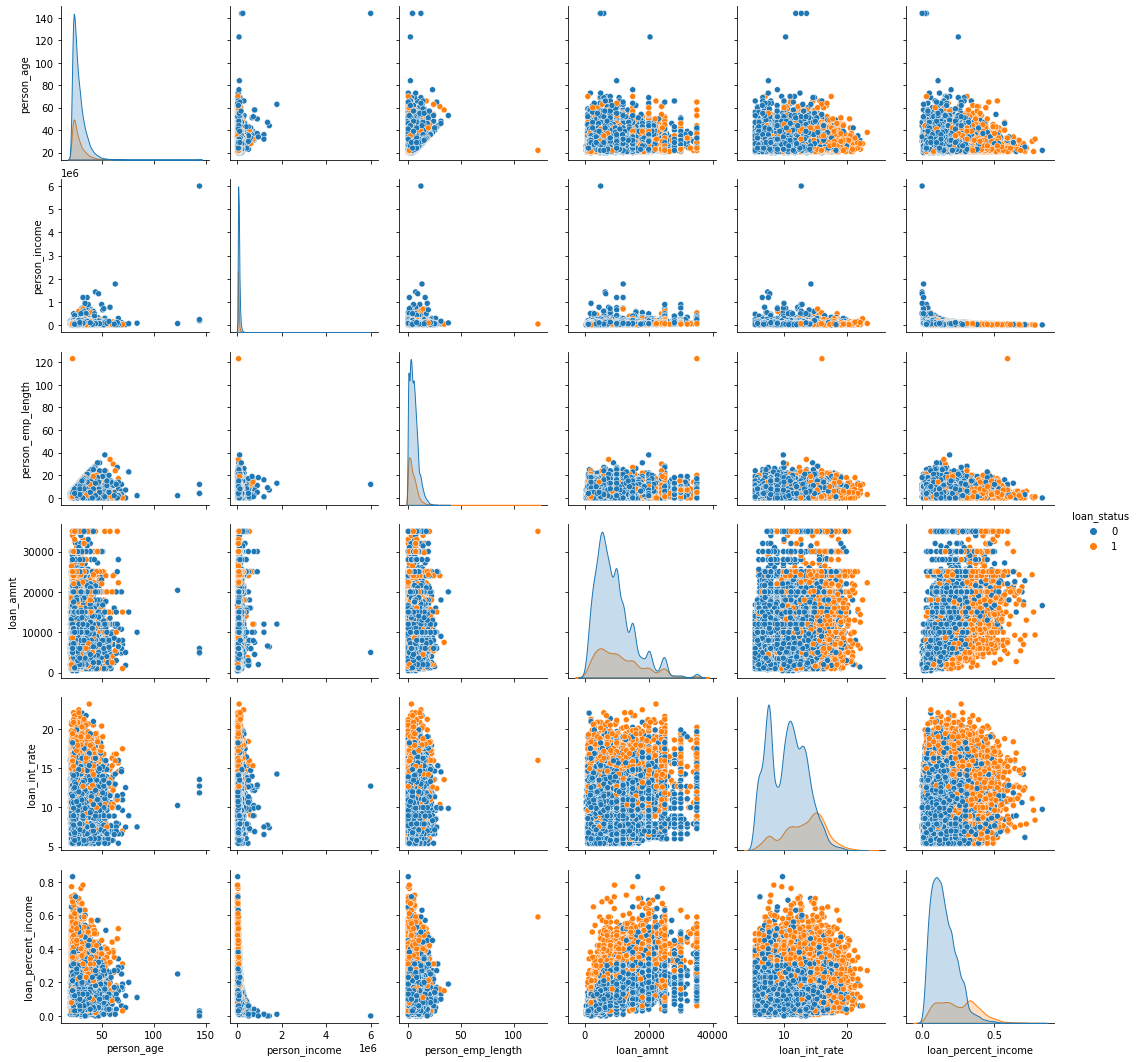

In [191]:
#Use pairplot to find obvious outliers
sns.pairplot(df, hue = 'loan_status')

In [192]:
#Remove numerical outliers
df = df[df['person_age']<100]
df = df[df['person_income']<3*10**6]
df = df[df['person_emp_length']<50]

<AxesSubplot:xlabel='cb_person_default_on_file', ylabel='count'>

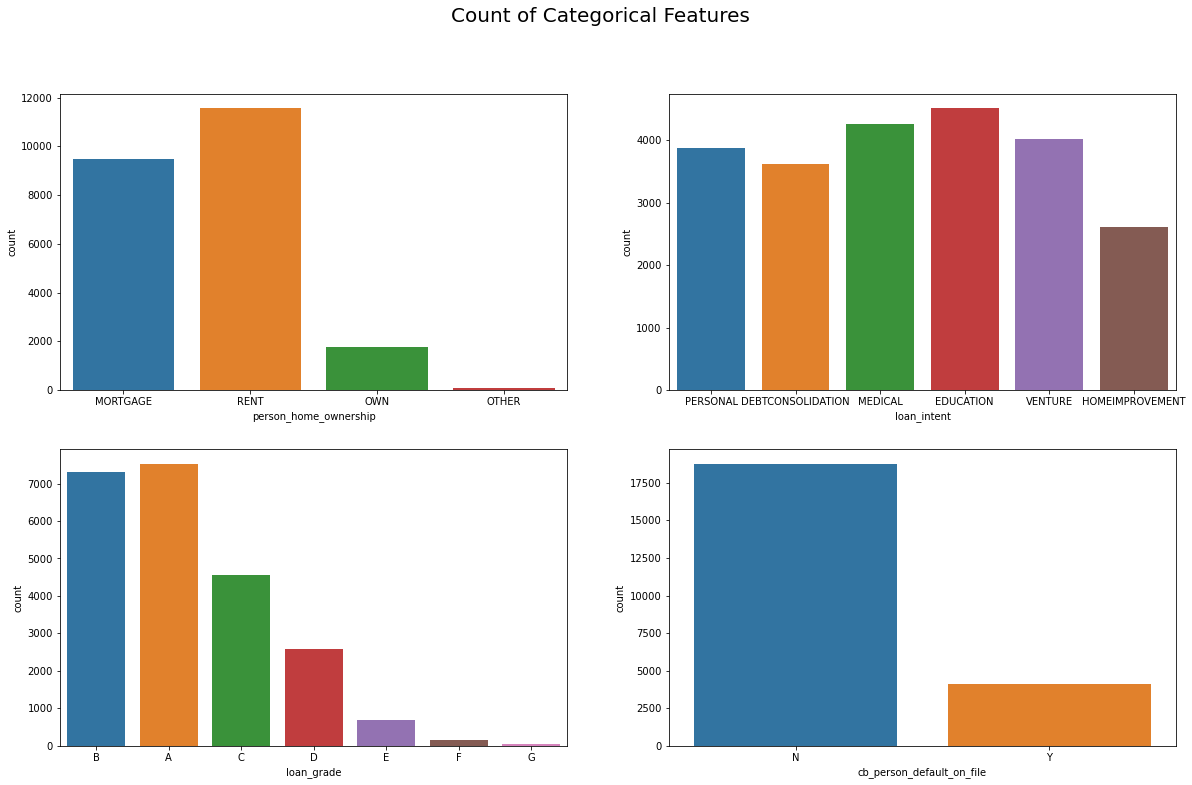

In [193]:
#Use countplot to find categorical outliers
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(20,12))
fig.suptitle("Count of Categorical Features", fontsize=20)
sns.countplot(x='person_home_ownership', data=df, ax=ax[0,0])
sns.countplot(x='loan_intent', data=df, ax=ax[0,1])
sns.countplot(x='loan_grade', data=df, ax=ax[1,0])
sns.countplot(x='cb_person_default_on_file', data=df, ax=ax[1,1])

In [194]:
#Convert categorical data into type categorical

df['person_home_ownership']=df['person_home_ownership'].astype('category')
df['loan_intent']=df['loan_intent'].astype('category')
df['loan_grade']=df['loan_grade'].astype('category')
df['cb_person_default_on_file']=df['cb_person_default_on_file'].astype('category')


In [195]:
#Remove categorical outliers

df = df[df['person_home_ownership']!='OTHER']
df = df[df['loan_grade']!='F']
df = df[df['loan_grade']!='G']
df['person_home_ownership'] = pd.Series(df['person_home_ownership']).cat.remove_unused_categories()


<AxesSubplot:xlabel='loan_status', ylabel='count'>

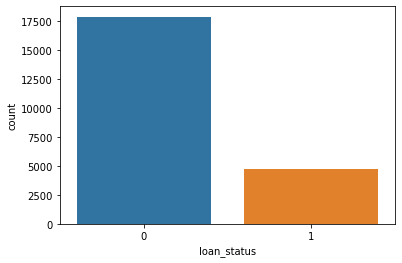

In [196]:
#Is the target balanced?
sns.countplot(data=df, x='loan_status')

In [197]:
#One-hot transform categorical data
df1 = pd.get_dummies(df)
df1.head(5)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,person_home_ownership_MORTGAGE,person_home_ownership_OWN,person_home_ownership_RENT,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,27,120000,3.0,14000,11.99,0,0.12,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1,24,58000,8.0,15700,7.90,0,0.27,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,30,45000,11.0,5000,12.73,1,0.11,0,0,1,...,0,0,0,1,0,0,0,0,0,1
3,35,35000,5.0,5600,11.49,0,0.16,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,38,55000,0.0,6500,11.03,0,0.12,0,0,1,...,0,0,0,1,0,0,0,0,0,1


F1: 0.8104621999283411
Accuracy: 0.9291359678499665
Recall: 0.7259306803594352
Precision: 0.9172749391727494


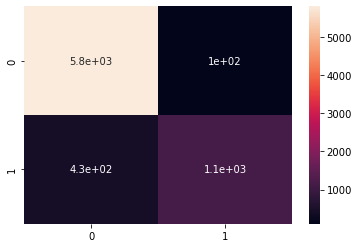

In [198]:
#Oversample loan_status = 1 to balance data
train1, test1 = train_test_split(df1, test_size=0.33)
y_test1 = np.array(test1['loan_status']).reshape(-1,1)
x_test1 = np.array(test1.drop(columns={'loan_status'}))

df_paid = train1[train1["loan_status"]==0]
df_notpaid = train1[train1["loan_status"]==1]
df_F = df_notpaid.sample(len(df_paid), replace=True)
df_Under = pd.concat([df_paid, df_F])
y_train1 = np.array(df_Under["loan_status"]).reshape(-1,1)
X_train1 = np.array(df_Under.drop(columns={"loan_status"}))

#Normalize data because features are not a normal distribution (Based on pairplots shown above)
scaler1 = MinMaxScaler()
X_train1_norm = scaler1.fit_transform(X_train1)
X_test1_norm = scaler1.transform(x_test1) 

#Train model
model = RandomForestClassifier(n_jobs=-1).fit(X_train1_norm,y_train1.ravel())

#Make predictions
preds1 = model.predict(X_test1_norm)

#Generate 1/0 results and show results
labels1 = binarize(np.array(preds1).reshape(-1,1), threshold=.5)
conf_matrix1 = confusion_matrix(y_test1,labels1)
sns.heatmap(conf_matrix1, annot=True)

print("F1:",f1_score(y_test1, labels1))
print("Accuracy:",accuracy_score(y_test1, labels1))
print("Recall:",recall_score(y_test1, labels1))
print("Precision:",precision_score(y_test1, labels1))

### Accuracy Test

Replace the green part with whatever you need to transform the fresh data into the format needed for your model to predict. 

<b>Note:</b> you could test and make sure that things are working OK here by taking part of your dataset, saving it in a separate CSV, and running it through here as a piece of test data. The accuracy results would be useless, but you'd confirm that the model works properly. 

F1: 0.7933491686460806
Accuracy: 0.9238845144356955
Recall: 0.6660019940179461
Precision: 0.9809104258443465


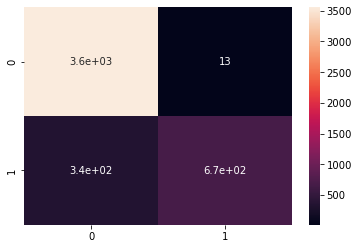

In [199]:
#Load any test data in same format as "train.csv"
d_test = pd.read_csv("test.csv")



######################
# Insert whatever you need to do to prep the data here. 
# It might be nothing if you have a big pipeline. 
# Ensure that at the end your data is in two arrays - xtest and ytest
# Ensure the name of your final model is "model"
# Each should contain the ENTIRE x or y dataset in the test data. 
#
# This part should be reusable - any dataset in this format should just run
# and generate predictions and accuracy stats. 
# Please DO NOT do any train-test splitting here.


#Filter outliers
d_test = d_test.iloc[: , 1:]
d_test = d_test.dropna()

d_test = d_test.drop(columns='cb_person_cred_hist_length')

d_test = d_test[d_test['person_age']<100]
d_test = d_test[d_test['person_income']<3*10**6]
d_test = d_test[d_test['person_emp_length']<50]

d_test['person_home_ownership']=d_test['person_home_ownership'].astype('category')
d_test['loan_intent']=d_test['loan_intent'].astype('category')
d_test['loan_grade']=d_test['loan_grade'].astype('category')
d_test['cb_person_default_on_file']=d_test['cb_person_default_on_file'].astype('category')

d_test = d_test[d_test['person_home_ownership']!='OTHER']
d_test = d_test[d_test['loan_grade']!='F']
d_test = d_test[d_test['loan_grade']!='G']
d_test['person_home_ownership'] = pd.Series(d_test['person_home_ownership']).cat.remove_unused_categories()

#One-hot transform
df2 = pd.get_dummies(d_test)

#Oversample loan_status = 1 to balance data
y_test2 = np.array(df2['loan_status']).reshape(-1,1)
x_test2 = np.array(df2.drop(columns={'loan_status'}))

df_paid2 = df2[df2["loan_status"]==0]
df_notpaid2 = df2[df2["loan_status"]==1]
df_F2 = df_notpaid2.sample(len(df_paid2), replace=True)
df_Under2 = pd.concat([df_paid2, df_F2])
y_train2 = np.array(df_Under2["loan_status"]).reshape(-1,1)
X_train2 = np.array(df_Under2.drop(columns={"loan_status"}))

#Normalize data because features are not a normal distribution (Based on pairplots shown above)
scaler2 = MinMaxScaler()
X_test2_norm = scaler2.fit_transform(x_test2)
X_test2_norm = scaler2.transform(x_test2) 

#Make predictions
preds2 = model.predict(X_test2_norm)

#######################

# This should work once you're done, as is. 
# uncomment the stuff below when ready to run.


#Generate 1/0 results and show results
labels2 = binarize(np.array(preds2).reshape(-1,1), threshold=.5)
conf_matrix2 = confusion_matrix(y_test2,labels2)
sns.heatmap(conf_matrix2, annot=True)

print("F1:",f1_score(y_test2, labels2))
print("Accuracy:",accuracy_score(y_test2, labels2))
print("Recall:",recall_score(y_test2, labels2))
print("Precision:",precision_score(y_test2, labels2))

 
